In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import solve_ivp
!pip install tikzplotlib #uncomment for saving nice images
import tikzplotlib
from pylab import *
# set precision
torch.set_default_dtype(torch.float64)
print('Default data type:', torch.get_default_dtype())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 1.2 MB/s 
Default data type: torch.float64


In [ ]:
import os, torch, pickle, zipfile, sys
import imageio, shutil
import scipy, scipy.misc, scipy.integrate
solve_ivp = scipy.integrate.solve_ivp



In [ ]:
!pip install hessquik
import hessQuik.activations as act
import hessQuik.layers as lay
import hessQuik.networks as net
from hessQuik.utils import  test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for hessquik: filename=hessQuik-0.0.1-py3-none-any.whl size=47429 sha256=6f48ebce396cea1d9c4af70058774e0c0f3f080b0a3338b09e9283e56cb382bf
  Stored in directory: /root/.cache/pip/wheels/a2/a6/89/e918c06b2593c4270617df1892a068a22a03cdf68f71a2aa13
Successfully built hessquik


In [ ]:
'''
Create dataset for models: functions for the different energies, dynamics, bodies, and their orbits

  Code from:
  Hamiltonian Neural Networks | 2019
  Sam Greydanus, Misko Dzamba, Jason Yosinski
https://github.com/greydanus/hamiltonian-nn/blob/master/experiment-2body/data.py
'''

def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=pickle.HIGHEST_PROTOCOL)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

##### ENERGY #####
def potential_energy(state):
    '''U=sum_i,j>i G m_i m_j / r_ij'''
    tot_energy = np.zeros((1,1,state.shape[2]))
    for i in range(state.shape[0]):
        for j in range(i+1,state.shape[0]):
            r_ij = ((state[i:i+1,1:3] - state[j:j+1,1:3])**2).sum(1, keepdims=True)**.5
            m_i = state[i:i+1,0:1]
            m_j = state[j:j+1,0:1]
    tot_energy += m_i * m_j / r_ij
    U = -tot_energy.sum(0).squeeze()
    return U

def kinetic_energy(state):
    '''T=sum_i .5*m*v^2'''
    energies = .5 * state[:,0:1] * (state[:,3:5]**2).sum(1, keepdims=True)
    T = energies.sum(0).squeeze()
    return T

def total_energy(state):
    return potential_energy(state) + kinetic_energy(state)


##### DYNAMICS #####
def get_accelerations(state, epsilon=0):
    # shape of state is [bodies x properties]
    net_accs = [] # [nbodies x 2]
    for i in range(state.shape[0]): # number of bodies
        other_bodies = np.concatenate([state[:i, :], state[i+1:, :]], axis=0)
        displacements = other_bodies[:, 1:3] - state[i, 1:3] # indexes 1:3 -> pxs, pys
        distances = (displacements**2).sum(1, keepdims=True)**0.5
        masses = other_bodies[:, 0:1] # index 0 -> mass
        pointwise_accs = masses * displacements / (distances**3 + epsilon) # G=1
        net_acc = pointwise_accs.sum(0, keepdims=True)
        net_accs.append(net_acc)
    net_accs = np.concatenate(net_accs, axis=0)
    return net_accs
  
def update(t, state):
    state = state.reshape(-1,5) # [bodies, properties]
    deriv = np.zeros_like(state)
    deriv[:,1:3] = state[:,3:5] # dx, dy = vx, vy
    deriv[:,3:5] = get_accelerations(state)
    return deriv.reshape(-1)


##### INTEGRATION SETTINGS #####
#this is the function we will be using to get our data for the two bodies 
def get_orbit(state, update_fn=update, t_points=100, t_span=[0,2], **kwargs):
    if not 'rtol' in kwargs.keys():
        kwargs['rtol'] = 1e-9

    orbit_settings = locals() #creates a dictionary of the local variables

    nbodies = state.shape[0]
    t_eval = np.linspace(t_span[0], t_span[1], t_points)
    orbit_settings['t_eval'] = t_eval

    path = solve_ivp(fun=update_fn, t_span=t_span, y0=state.flatten(),
                     t_eval=t_eval, **kwargs)
    orbit = path['y'].reshape(nbodies, 5, t_points)
    #returns orbit: 3D array, for us 2 bodies, 5 values, for each timestep
    # and orbit_settings: dictionary of local vars, state, update_fn, t_points, t_span, kwargs, t_eval
    return orbit, orbit_settings


##### INITIALIZE THE TWO BODIES #####
def random_config(orbit_noise=5e-2, min_radius=0.5, max_radius=1.5):
    state = np.zeros((2,5))
    state[:,0] = 1
    pos = np.random.rand(2) * (max_radius-min_radius) + min_radius
    r = np.sqrt( np.sum((pos**2)) )

    # velocity that yields a circular orbit
    vel = np.flipud(pos) / (2 * r**1.5)
    vel[0] *= -1
    vel *= 1 + orbit_noise*np.random.randn()

    # make the circular orbits SLIGHTLY elliptical
    state[:,1:3] = pos
    state[:,3:5] = vel
    state[1,1:] *= -1
    return state


##### HELPER FUNCTION #####
def coords2state(coords, nbodies=2, mass=1):
    timesteps = coords.shape[0]
    state = coords.T
    state = state.reshape(-1, nbodies, timesteps).transpose(1,0,2)
    mass_vec = mass * np.ones((nbodies, 1, timesteps))
    state = np.concatenate([mass_vec, state], axis=1)
    return state


##### INTEGRATE AN ORBIT OR TWO #####
def sample_orbits(timesteps=4001, trials=1, nbodies=2, orbit_noise=5e-2,
                  min_radius=0.5, max_radius=1.5, t_span=[0, 20], verbose=False, **kwargs):
    
    orbit_settings = locals()
    if verbose:
        print("Making a dataset of near-circular 2-body orbits:")
    
    x, dx, e = [], [], []
    N = timesteps*trials
    while len(x) < N:

        state = random_config(orbit_noise, min_radius, max_radius)
        orbit, settings, t_eval = get_orbit(state, t_points=timesteps, t_span=t_span, **kwargs)
        batch = orbit.transpose(2,0,1).reshape(-1,10)

        for state in batch:
            dstate = update(None, state)
            
            # reshape from [nbodies, state] where state=[m, qx, qy, px, py]
            # m is assumed to be 1
            # to [canonical_coords] = [qx1, qx2, qy1, qy2, px1,px2,....]
            coords = state.reshape(nbodies,5).T[1:].flatten()
            dcoords = dstate.reshape(nbodies,5).T[1:].flatten() #derivatives
            x.append(coords)
            dx.append(dcoords)

            shaped_state = state.copy().reshape(2,5,1)
            e.append(total_energy(shaped_state))

    data = {'coords': np.stack(x)[:N],
            'dcoords': np.stack(dx)[:N],
            'energy': np.stack(e)[:N] }
    return data, orbit_settings


##### MAKE A DATASET #####
def make_orbits_dataset(test_split=0.2, **kwargs):
    data, orbit_settings = sample_orbits(**kwargs)
    
    # make a train/test split
    # split_ix = int(data['coords'].shape[0] * test_split)
    # split_data = {}
    # for k, v in data.items():
    #     split_data[k], split_data['test_' + k] = v[split_ix:], v[:split_ix]
    # data = split_data

    data['meta'] = orbit_settings
    return data


##### LOAD OR SAVE THE DATASET #####
def get_dataset(experiment_name, save_dir, **kwargs):
    '''Returns an orbital dataset. Also constructs
    the dataset if no saved version is available.'''

    path = '{}/{}-orbits-dataset.pkl'.format(save_dir, experiment_name)

    try:
        data = from_pickle(path)
        print("Successfully loaded data from {}".format(path))
    except:
        print("Had a problem loading data from {}. Rebuilding dataset...".format(path))
        data = make_orbits_dataset(**kwargs)
        to_pickle(data, path)

    return data

In [ ]:
!pwd

/content


In [ ]:
np.random.seed(2)
state = random_config()
orbit, settings = get_orbit(state, t_points=4001, t_span = [0, 20], rtol = 1e-10) # this gives us the data


In [ ]:
for x in settings:
  print(x)
#for y in orbit:
 # print(y)
print(len(orbit))
print(len(orbit[0]))
print(len(orbit[0][0]))

state
update_fn
t_points
t_span
kwargs
t_eval
2
5
4001


In [ ]:
'''
Set up training values 

'''

n_train = 4000      # number of training points
n_samples = n_train
x_train = np.zeros([2,5,n_train])
x_train[:,0,:] = settings['t_eval'][:n_train]
x_train[:,1:5,:] = orbit[:,1:,:n_train]
y_train = orbit[:,1:,1:n_train+1]
x_train, y_train = torch.tensor(x_train), torch.tensor(y_train)
# x_val, y_val = x_train[:,:,100:1000], y_train[:,:,100:1000]
# x_test, y_test = x_train[:,:,100:3000], y_train[:,:,100:3000]

#print(x_train.shape) #[2, 5, 4000]
#print(y_train.shape) #[2, 4, 4000]

# shuffle and split data
# idx = torch.randperm(n_train + n_val + n_test)
# x_train, y_train = x[idx[:n_train]], y[idx[:n_train]]
# x_val, y_val = x[idx[n_train:n_train + n_val]], y[idx[n_train:n_train + n_val]]
# x_test, y_test = x[idx[n_train + n_val:]], y[idx[n_train + n_val:]]

stepSize = 20/4001
print("stepsize=", stepSize)

stepsize= 0.0049987503124218945


In [ ]:
'''
Create our Network:
  - our width and depth, as well as the function we use to create our ResNet

'''

width = 20
depth = 3
f = net.NN(lay.singleLayer(10, width, act=act.tanhActivation()),
           net.resnetNN(width, depth, h=0.5, act=act.tanhActivation()),
           lay.singleLayer(width, 1, act=act.identityActivation()))

# Pytorch optimizer for the network weights
optimizer = torch.optim.Adam(f.parameters(), lr=1e-3) 
#weight decay is for regularization weight_decay=1e-5 add this for regularization


### Transform x_train to nex-by-10 and y_train to nex-by-8

In [ ]:
#Transform x_train to nex-by-10 and y_train to nex-by-8

x_train = torch.cat((x_train[0,:,:],x_train[1,:,:]),axis=0).t()
y_train = torch.cat((y_train[0,:,:],y_train[1,:,:]),axis=0).t()
x_val, y_val = x_train[100:1000,:], y_train[100:1000,:]
x_test, y_test = x_train[100:3000,:], y_train[100:3000,:]

In [ ]:
print(x_train.size()) #[4000, 10]
print(x_val.size()) #[900, 10]
print(x_test.size()) #[2900, 10]

torch.Size([4000, 10])
torch.Size([900, 10])
torch.Size([2900, 10])


In [ ]:
#Neural Net on our Training data (f is our function to make the net)

f_train = f(x_train,do_gradient=True,do_hessian = False) 
f_train[1][:,1:3,0].shape

torch.Size([4000, 2])

In [ ]:
# Test Time stepping
y1 = stepSize*f_train[1][:,3:5,0]  + x_train[:,1:3] 
z1 = -1 * stepSize*f_train[1][:,1:3,0] + x_train[:,3:5] 
y2 = stepSize*f_train[1][:,8:10,0]  + x_train[:,6:8] 
z2 = -1 * stepSize*f_train[1][:,6:8,0] + x_train[:,8:10]
torch.cat((y1,z1,y2,z2),dim=1).shape

torch.Size([4000, 8])

In [ ]:
#Our Mean Squared Error Loss Function
def mse_loss(y_true: torch.Tensor,y: torch.Tensor):
  return (0.5 / y.shape[0]) * torch.norm(y_true - y.view_as(y_true)) ** 2

In [ ]:
#A function for printing the various headers necessary for seeing our network running
def print_headers( verbose: bool = True):
    r"""
    Print headers for nice training
    """
    loss_printouts = ('loss',)
    n_loss = len(loss_printouts)

    headers = (('', '', '|', 'running',) + (n_loss - 1) * ('',) + ('|', 'train',)
               + (n_loss - 1) * ('',) + ('|', 'valid',) + (n_loss - 1) * ('',))

    printouts = ('epoch', 'time') + 3 * (('|',) + loss_printouts)
    printouts_frmt = '{:<15d}{:<15.4f}' + 3 * ('{:<2s}' + n_loss * '{:<15.4e}')

    if verbose:
        print(('{:<15s}{:<15s}' + 3 * ('{:<2s}' + n_loss * '{:<15s}')).format(*headers))
        print(('{:<15s}{:<15s}' + 3 * ('{:<2s}' + n_loss * '{:<15s}')).format(*printouts))

    return headers, printouts, printouts_frmt

                              | running        | train          | valid          
epoch          time           | loss           | loss           | loss           
0              0.2587         | 1.4554e-05     | 1.1999e-05     | 1.2745e-05     
5              0.2038         | 7.6044e-06     | 7.3270e-06     | 4.1514e-06     
10             0.1521         | 4.6359e-06     | 4.2711e-06     | 1.4807e-06     
15             0.2420         | 1.8058e-06     | 1.5523e-06     | 5.5587e-07     
20             0.1721         | 5.0285e-07     | 4.5448e-07     | 4.4422e-07     
25             0.1888         | 2.6667e-07     | 2.5471e-07     | 2.3868e-07     
30             0.2051         | 1.9991e-07     | 1.9473e-07     | 1.7341e-07     
35             0.1881         | 1.6623e-07     | 1.6310e-07     | 1.3871e-07     
40             0.2286         | 1.4314e-07     | 1.4077e-07     | 1.1472e-07     
45             0.1660         | 1.2432e-07     | 1.2329e-07     | 9.6661e-08     
50             0

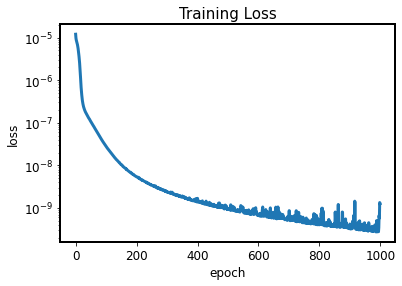

In [ ]:
'''
Training our Network
  - Print the table detailing various losses over epochs, and produce a figure 
    showing the training loss as the epochs go on.

'''

# training parameters
max_epochs = 1000
batch_size = 500

# get printouts
headers, printouts_str, printouts_frmt = print_headers()

# ---------------------------------------------------------------------------- #
# initial evaluation -> initial training values and gradient
f_train = f(x_train,do_gradient=True,do_hessian = False) 
#now construct the neural nets for validation

#For printing: 
his_iter = (-1, 0.0) + ('|',) + (0,) + ('|',) + (0,) + ('|',) + (0,)
# print(printouts_frmt.format(*his_iter))

# store history
his = np.array([x for x in his_iter if not (x == '|')]).reshape(1, -1)


# ---------------------------------------------------------------------------- #
# main iteration of training 

log_interval = 5 # how often printouts appear
for epoch in range(max_epochs): #go through each epoch
    t0 = time.perf_counter()
    # training here
    f.train()
    n = x_train.shape[0] #number of inputs
    b = batch_size
    n_batch = n // b #inputs per batch
    loss = torch.zeros(1) #initializing loss
    running_loss = 0.0

    # shuffle
    idx = torch.randperm(n) #identity

    for i in range(n_batch): #loop through batches
        idxb = idx[i * b:(i + 1) * b] #random permute based on batch number
        xb, yb = x_train[idxb], y_train[idxb] #get that batch data
        optimizer.zero_grad()
        f_batch= f(xb,do_gradient=True,do_hessian = False) #gradient and vals for this batch

        #time steps (like we saw earlier)
        y1 = stepSize*f_batch[1][:,3:5,0]  + xb[:,1:3] 
        z1 = -1 * stepSize*f_batch[1][:,1:3,0] + xb[:,3:5] 
        y2 = stepSize*f_batch[1][:,8:10,0]  + xb[:,6:8] 
        z2 = -1 * stepSize*f_batch[1][:,6:8,0] + xb[:,8:10]
        # torch.cat((y1,z1,y2,z2),dim=1).shape
        loss = mse_loss(torch.cat((y1,z1,y2,z2),dim=1),yb) 
        running_loss += b * loss.item()

        # update network weights
        loss.backward(retain_graph=True) #back propagation 
        optimizer.step() #step so we can then do the next batch

    running_loss = (running_loss / n,) #averge it 
    
    t1 = time.perf_counter()

    # test
    fc_train= f(x_train,do_gradient=True,do_hessian = False)

    y1 = stepSize*fc_train[1][:,3:5,0]  + x_train[:,1:3] 
    z1 = -1 * stepSize*fc_train[1][:,1:3,0] + x_train[:,3:5] 
    y2 = stepSize*fc_train[1][:,8:10,0]  + x_train[:,6:8] 
    z2 = -1 * stepSize*fc_train[1][:,6:8,0] + x_train[:,8:10]
    
    loss_train = mse_loss(torch.cat((y1,z1,y2,z2),dim=1),y_train)

    #validation
    fc_val= f(x_val,do_gradient=True,do_hessian = False)
    
    y1 = stepSize*fc_val[1][:,3:5,0]  + x_val[:,1:3] 
    z1 = -1 * stepSize*fc_val[1][:,1:3,0] + x_val[:,3:5] 
    y2 = stepSize*fc_val[1][:,8:10,0]  + x_val[:,6:8] 
    z2 = -1 * stepSize*fc_val[1][:,6:8,0] + x_val[:,8:10]
    
    loss_val = mse_loss(torch.cat((y1,z1,y2,z2),dim=1),y_val)
    t = t1-t0

    #for printing:
    his_iter = (epoch, t1 - t0) + ('|',) + running_loss + ('|',) + (loss_train.item(),) + ('|',) + (loss_val.item(),)
    if epoch % log_interval == 0:
      print(printouts_frmt.format(*his_iter))

    # store history
    idx = [idx for idx, n in enumerate(np.array([x for x in printouts_str if not (x == '|')])) if n == 'loss'][1]
    his = np.concatenate((his, np.array([x for x in his_iter if not (x == '|')]).reshape(1, -1)), axis=0)


# ---------------------------------------------------------------------------- #
# overall performance on test data
f_test= f(x_test,do_gradient=True,do_hessian = False)
y1 = stepSize*f_test[1][:,3:5,0]  + x_test[:,1:3] 
z1 = -1 * stepSize*f_test[1][:,1:3,0] + x_test[:,3:5] 
y2 = stepSize*f_test[1][:,8:10,0]  + x_test[:,6:8] 
z2 = -1 * stepSize*f_test[1][:,6:8,0] + x_test[:,8:10]

loss_test = mse_loss(torch.cat((y1,z1,y2,z2),dim=1),y_test)
print('Test Loss: %0.4e' % loss.item())



# ---------------------------------------------------------------------------- #
#For Convergence Plot:

fs=15; tpad=6; lw=3; ms=30

rc('axes', linewidth=2)
fig = plt.figure()
idx = [idx for idx, n in enumerate(np.array([x for x in printouts_str if not (x == '|')])) if n == 'loss'][1]

plt.semilogy(his[1::, 0], his[1::, idx], linewidth=lw)

plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.title('Training Loss', fontsize=fs) 
ax = gca()
#plt.legend()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)

plt.show()
fig.savefig('conv_plot.png',dpi=600, bbox_inches = 'tight', pad_inches = 0.05) #to save the image


In [ ]:
# Go back and solve the ODE, put info in sol array

xinit = x_train[0:1,:]
steps = 3000
h = stepSize
sol = torch.zeros(steps,8) #initialize
t_solspan = np.zeros(steps) #initialize
t=0

for i in range(steps): #for each step
  fb = f(xinit,do_gradient=True,do_hessian = False) #plug x_init

  y1 = stepSize*fb[1][:,3:5,0]  + xinit[:,1:3] 
  z1 = -1 * stepSize*fb[1][:,1:3,0] + xinit[:,3:5] 
  y2 = stepSize*fb[1][:,8:10,0]  + xinit[:,6:8] 
  z2 = -1 * stepSize*fb[1][:,6:8,0] + xinit[:,8:10]

  t = t + h
  t_solspan[i] = t
  xinit = torch.cat((xinit[0:1,0:1] + h, y1, z1, xinit[0:1,5:6] + h, y2, z2),dim=1)
  sol[i:i+1,:] =  torch.cat(( y1, z1, y2, z2),dim=1) #store in solutions
# t_solspan[1] = t

In [ ]:
sol = sol.t().detach().numpy()

In [ ]:
orbit_sol = np.ones((2,5,steps))
orbit_sol[0,1:5,:] = sol[:4,:]
orbit_sol[1,1:5,:] = sol[4:8,:]

In [ ]:
orbit_sol.shape


(2, 5, 3000)

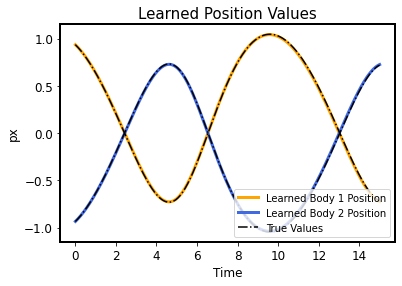

In [ ]:
#Here we are plotting our learned positions against the true positions

fs=15; tpad=6; lw=3; ms=30

plt.title('Learned Position Values', fontsize=fs)

#lines
plt.plot(t_solspan,orbit_sol[0][1,:], "k-",linewidth=lw,  color = "orange", label='Learned Body 1 Position'.format(i))
plt.plot(t_solspan,orbit_sol[1][1,:], "k-", linewidth=lw, color = "royalblue", label='Learned Body 2 Position'.format(i))

holder = 0

plt.plot(settings['t_eval'][:steps],orbit[0][1,:steps], "k-.", label='True Values')
plt.plot(settings['t_eval'][:steps],orbit[1][1,:steps], "k-.")

#labels
plt.xlabel('Time', fontsize=12) 
plt.ylabel('px', fontsize=12)
plt.legend(fontsize=7, loc='lower right', prop={'size':10})

ax = gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)

plt.savefig('learned position.png',dpi=600, bbox_inches = 'tight', pad_inches = 0.05) 

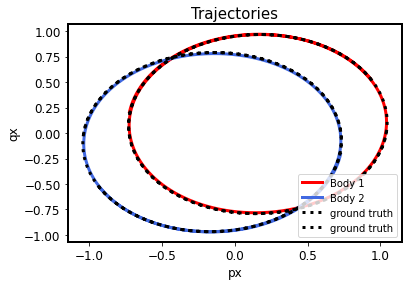

In [ ]:
#Plot the predicted Trajectories of our bodies
fs=15; tpad=6; lw=3; ms=30
rc('axes', linewidth=2)

plt.title('Trajectories', fontsize=fs, pad=tpad)
colors = ["red", "royalblue"]
labels = ["Body 1", "Body 2"]
plt.xlabel('px', fontsize=12) 
plt.ylabel('qx', fontsize=12)


ax = gca()

for i, path in enumerate(orbit_sol):
    plt.plot(path[1], path[2], "k-", linewidth=lw, color = colors[i], label=labels[i].format(i))
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], "k:", linewidth=lw, label='ground truth'.format(i))
plt.legend(fontsize=7, loc='lower right', prop={'size':10})

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)

plt.savefig('Trajectories.png',dpi=600, bbox_inches = 'tight', pad_inches = 0.05) 

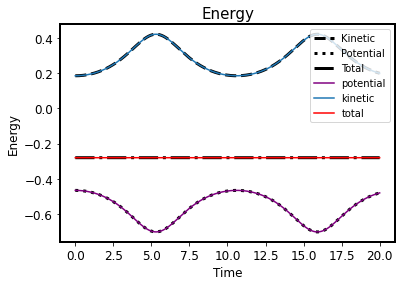

In [ ]:
#Plot the energy values


tail=10000; pfrac=0.05


k = 4001


tstart = max(0, k-tail)

real_pe = potential_energy(orbit[...,tstart:k])
real_ke = kinetic_energy(orbit[...,tstart:k])
real_etot = total_energy(orbit[...,tstart:k])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
pad = (ymax-ymin)*pfrac
ymin -= pad
ymax += pad
rc('axes', linewidth=2)

#lines
plt.plot(settings['t_eval'], real_ke,'k--', linewidth=lw, label='Kinetic')
plt.plot(settings['t_eval'], real_pe,'k:', linewidth=lw, label='Potential')
plt.plot(settings['t_eval'], real_etot,'k-.', linewidth=lw, label='Total')
plt.plot(settings['t_eval'], potential_energy(orbit), label='potential', color = 'purple')
plt.plot(settings['t_eval'], kinetic_energy(orbit), label='kinetic')
plt.plot(settings['t_eval'], total_energy(orbit), label='total', color = "red")

ax = gca()

#labels
plt.title('Energy', fontsize=fs, pad=tpad)
plt.xlabel('Time', fontsize=12) 
plt.ylabel("Energy", fontsize=12)
plt.ylim(ymin, ymax)
plt.legend(fontsize=7, loc='best', prop={'size':10})

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)

plt.savefig('Energy.png',dpi=600, bbox_inches = 'tight', pad_inches = 0.05) 

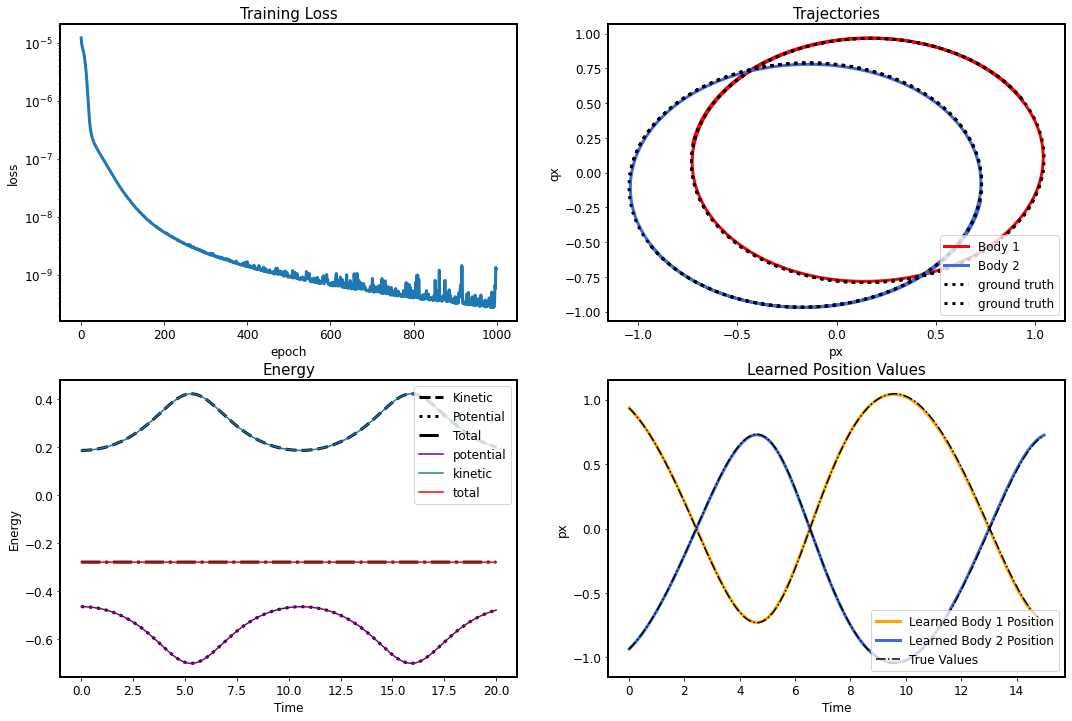

In [ ]:
'''
All Four Figures in One Rectangle
  - Edit the sizing for scaling, and add or remove whitspace with pad_inches

'''

fs=15; tpad=6; lw=3; ms=30


# convergence plot
rc('axes', linewidth=2)
fig = plt.figure(figsize=(18, 12))
plt.subplot(2, 2, 1)
idx = [idx for idx, n in enumerate(np.array([x for x in printouts_str if not (x == '|')])) if n == 'loss'][1]

plt.semilogy(his[1::, 0], his[1::, idx], linewidth=lw)

#labels
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.title('Training Loss', fontsize=fs) 

ax = gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)



#Plot the trajectories

rc('axes', linewidth=2)


plt.subplot(2, 2, 2)
plt.title('Trajectories', fontsize=fs, pad=tpad)
colors = ["red", "royalblue"]
labels = ["Body 1", "Body 2"]
plt.xlabel('px', fontsize=12) 
plt.ylabel('qx', fontsize=12)



ax = gca()

for i, path in enumerate(orbit_sol):
    plt.plot(path[1], path[2], "k-", linewidth=lw, color = colors[i], label=labels[i].format(i))
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], "k:", linewidth=lw, label='ground truth'.format(i))
plt.legend(fontsize=7, loc='lower right', prop={'size':12})

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)


#Plot the energy values

tail=10000; pfrac=0.05


k = 4001


tstart = max(0, k-tail)

real_pe = potential_energy(orbit[...,tstart:k])
real_ke = kinetic_energy(orbit[...,tstart:k])
real_etot = total_energy(orbit[...,tstart:k])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
pad = (ymax-ymin)*pfrac
ymin -= pad
ymax += pad


rc('axes', linewidth=2)

#lines
plt.subplot(2, 2, 3)
plt.title('Energy', fontsize=fs, pad=tpad)
plt.plot(settings['t_eval'], real_ke,'k--', linewidth=lw, label='Kinetic')
plt.plot(settings['t_eval'], real_pe,'k:', linewidth=lw, label='Potential')
plt.plot(settings['t_eval'], real_etot,'k-.', linewidth=lw, label='Total')
plt.plot(settings['t_eval'], potential_energy(orbit), label='potential', color = 'purple')
plt.plot(settings['t_eval'], kinetic_energy(orbit), label='kinetic')
plt.plot(settings['t_eval'], total_energy(orbit), label='total', color = "red")

ax = gca()

#labels
plt.xlabel('Time', fontsize=12) 
plt.ylabel("Energy", fontsize=12)
plt.ylim(ymin, ymax)
plt.legend(fontsize=7, loc='best', prop={'size':12})

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)



#Plot the learned vs ground positions

plt.subplot(2, 2, 4)

#lines
plt.plot(t_solspan,orbit_sol[0][1,:], "k-",linewidth=lw,  color = "orange", label='Learned Body 1 Position'.format(i))
plt.plot(t_solspan,orbit_sol[1][1,:], "k-", linewidth=lw, color = "royalblue", label='Learned Body 2 Position'.format(i))

holder = 0

ax = gca()

plt.plot(settings['t_eval'][:steps],orbit[0][1,:steps], "k-.", label='True Values')
plt.plot(settings['t_eval'][:steps],orbit[1][1,:steps], "k-.")

#labels
plt.title('Learned Position Values', fontsize=fs)
plt.xlabel('Time', fontsize=12) 
plt.ylabel('px', fontsize=12)
plt.legend(fontsize=7, loc='lower right', prop={'size':12})

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)

fig.savefig('2 Body Combo.png',dpi=600, bbox_inches = 'tight', pad_inches = 0.05) 
#tikzplotlib.save('energy.tex')